## Importing the dataset and primary libraries

In [1]:
import pandas as pd
import numpy as np
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn import metrics
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_curve, auc
kickstart=pd.read_csv("ks-projects-201801.csv")

In [62]:
kickstart.shape

(378654, 56)

In [56]:
kickstart.head()

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,...,EUR,GBP,HKD,JPY,MXN,NOK,NZD,SEK,SGD,USD
169268,1860890148,Grace Jones Does Not Give A F$#% T-Shirt (limi...,Fashion,Fashion,USD,2009-05-31,1000.0,2009-04-21 21:02:48,625.0,failed,...,0,0,0,0,0,0,0,0,0,1
322000,709707365,CRYSTAL ANTLERS UNTITLED MOVIE,Shorts,Film & Video,USD,2009-07-20,80000.0,2009-04-23 00:07:53,22.0,failed,...,0,0,0,0,0,0,0,0,0,1
138572,1703704063,drawing for dollars,Illustration,Art,USD,2009-05-03,20.0,2009-04-24 21:52:03,35.0,successful,...,0,0,0,0,0,0,0,0,0,1
325391,727286,Offline Wikipedia iPhone app,Software,Technology,USD,2009-07-14,99.0,2009-04-25 17:36:21,145.0,successful,...,0,0,0,0,0,0,0,0,0,1
122662,1622952265,Pantshirts,Fashion,Fashion,USD,2009-05-26,1900.0,2009-04-27 14:10:39,387.0,failed,...,0,0,0,0,0,0,0,0,0,1


In [63]:
kickstart.dtypes

ID                            int64
name                         object
category                     object
main_category                object
currency                     object
deadline             datetime64[ns]
goal                        float64
launched             datetime64[ns]
pledged                     float64
state                        object
backers                       int64
country                      object
usd pledged                 float64
usd_pledged_real            float64
usd_goal_real               float64
camp_length         timedelta64[ns]
days                          int64
launch_month                  int64
launch_year                   int64
ratio                       float64
pledge_ratio                float64
canceled                      uint8
failed                        uint8
live                          uint8
successful                    uint8
suspended                     uint8
undefined                     uint8
Art                         

### Checking for missing data

In [2]:
kickstart.isna().sum()

ID                     0
name                   4
category               0
main_category          0
currency               0
deadline               0
goal                   0
launched               0
pledged                0
state                  0
backers                0
country                0
usd pledged         3797
usd_pledged_real       0
usd_goal_real          0
dtype: int64

### Investigating the issue with the usd pledged column

In [3]:
kickstart[kickstart['usd pledged'].isna()]

,ID,name,category,main_category,currency,deadline,goal,launched,pledged,state,backers,country,usd pledged,usd_pledged_real,usd_goal_real
169,1000694855,STREETFIGHTERZ WHEELIE MURICA,Film & Video,Film & Video,USD,2014-09-20,6500.0,2014-08-06 21:28:36,555.00,undefined,0,"N,0""",NaN,555.00,6500.00
328,100149523,Duncan Woods - Chameleon EP,Music,Music,AUD,2015-08-25,4500.0,2015-08-04 12:05:17,4767.00,undefined,0,"N,0""",NaN,3402.08,3211.53
632,1003023003,The Making of Ashley Kelley's Debut Album,Music,Music,USD,2015-04-09,3500.0,2015-03-10 20:06:13,3576.00,undefined,0,"N,0""",NaN,3576.00,3500.00
647,1003130892,Butter Side Down Debut Album,Music,Music,USD,2015-11-26,6000.0,2015-11-02 22:09:19,7007.80,undefined,0,"N,0""",NaN,7007.80,6000.00
749,1003629045,Chase Goehring debut EP,Music,Music,USD,2016-03-21,3000.0,2016-02-23 03:09:49,3660.38,undefined,0,"N,0""",NaN,3660.38,3000.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
378233,997971307,"EQUUS International Film Festival®, all-equine...",Film & Video,Film & Video,USD,2015-02-03,7500.0,2014-12-05 04:19:14,10.00,undefined,0,"N,0""",NaN,10.00,7500.00
378303,998319149,Emily 2050 - Short Film,Film & Video,Film & Video,CAD,2014-05-23,3000.0,2014-04-08 00:30:09,3102.00,undefined,0,"N,0""",NaN,2845.61,2752.04
378434,9988744,Matthew Stephens Music,Music,Music,USD,2016-02-05,5000.0,2016-01-06 21:59:23,235.00,undefined,0,"N,0""",NaN,235.00,5000.00
378585,999610349,Lady Vendredi: Afrofuturist concept 12 inch EP,Music,Music,GBP,2015-10-19,2000.0,2015-09-21 22:33:18,2125.00,undefined,0,"N,0""",NaN,3273.36,3080.81


### usd pledged is merely a conversion made by kickstarter, while usd_pledged_real was made by an external currency converter (and has no missing data). So the missing data is not an issue in this case; we just have to use the usd_pledged_real column.

In [4]:
kickstart.drop(columns=['usd pledged','pledged']);

### Now we convert the launched and deadline columns into datetime objects to manipulate and analyze them easier. We also add a new column, campLength, which is the length of the campaign, then extract the day attribute from this new column to create the days column.

### Removing the campaigns that last longer than 365 days helps deal with the few campaigns that have 1/1/1970 set as their launch date.

In [5]:
kickstart['launched']=pd.to_datetime(kickstart['launched'])
kickstart['deadline']=pd.to_datetime(kickstart['deadline'])
kickstart['camp_length']=kickstart['deadline']-kickstart['launched']
kickstart['days']=kickstart['camp_length'].dt.days
kickstart=kickstart[kickstart['days']<365]

In [6]:
kickstart['launch_month']=kickstart.launched.dt.month
kickstart['launch_year']=kickstart.launched.dt.year
kickstart['ratio']=kickstart['usd_pledged_real']/kickstart['usd_goal_real']
kickstart['pledge_ratio']=kickstart['usd_pledged_real']/kickstart['backers']

In [7]:
kickstart.pledge_ratio=kickstart.pledge_ratio.fillna(0.0)
kickstart.pledge_ratio=kickstart.pledge_ratio.replace([np.inf, -np.inf], 0.0)

In [8]:
# Prepare data for bar chart of annual campaign count
kickstart=kickstart.sort_values(['launched'])
success=kickstart[(kickstart['state']=="successful")&(kickstart['ratio']>=1)]
failure=kickstart[(kickstart['state']=="failed")&(kickstart['ratio']<1)]

annual=pd.DataFrame(kickstart.launch_year.value_counts())
annualSorted=pd.DataFrame(annual.sort_index())
annualSuccess=pd.DataFrame(success.launch_year.value_counts())
annualSuccessSorted=pd.DataFrame(annualSuccess.sort_index())
annualFailure=pd.DataFrame(failure.launch_year.value_counts())
annualFailureSorted=pd.DataFrame(annualFailure.sort_index())

monthly=pd.DataFrame(kickstart.launch_month.value_counts())
monthlySorted=pd.DataFrame(monthly.sort_index())
monthlySuccess=pd.DataFrame(success.launch_month.value_counts())
monthlySuccessSorted=pd.DataFrame(monthlySuccess.sort_index())
monthlyFailure=pd.DataFrame(failure.launch_month.value_counts())
monthlyFailureSorted=pd.DataFrame(monthlyFailure.sort_index())

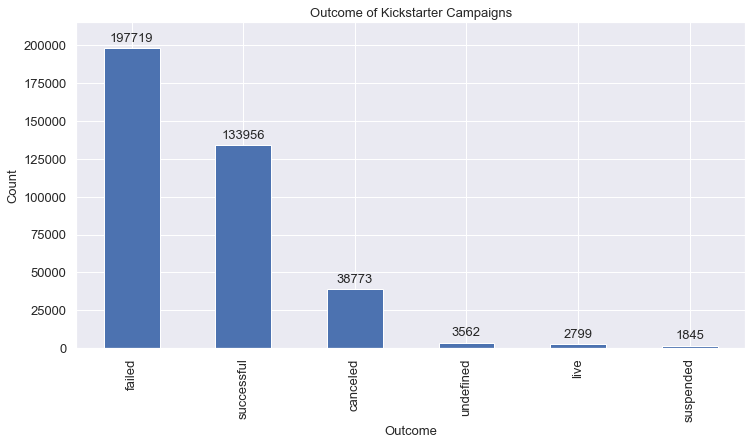

In [9]:
ax=kickstart['state'].value_counts().plot(kind='bar',fontsize=13,figsize=(12,6))
ax.set_title("Outcome of Kickstarter Campaigns",fontsize=13)
ax.set_ylabel("Count",fontsize=13)
ax.set_xlabel("Outcome",fontsize=13)
ax.set_ylim(0,215000)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=13)
plt.show()

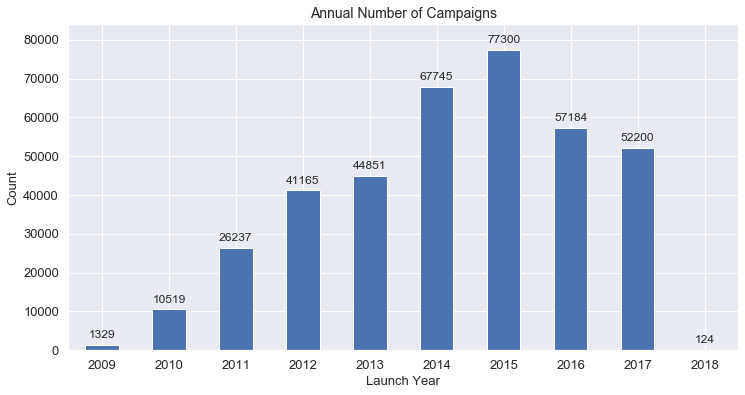

In [10]:
ax=annualSorted.plot(kind='bar',fontsize=13,figsize=(12,6))
ax.set_title("Annual Number of Campaigns",fontsize=14)
ax.set_ylabel("Count",fontsize=13)
ax.set_xlabel("Launch Year",fontsize=13)
ax.set_ylim(0,84000)
ax.tick_params(rotation=0)

# Add numbers above bars
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=12)
ax.get_legend().remove()
plt.show()

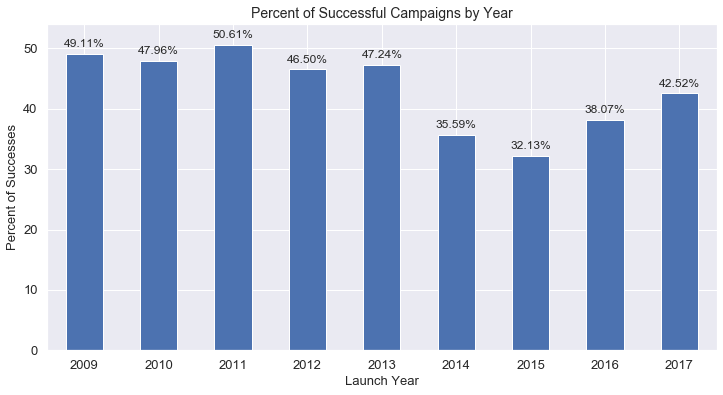

In [12]:
ax=((annualSuccessSorted)/(annualSuccessSorted+annualFailureSorted)*100).plot(kind='bar',fontsize=13,figsize=(12,6))
ax.set_title("Percent of Successful Campaigns by Year",fontsize=14)
ax.set_ylabel("Percent of Successes",fontsize=13)
ax.set_xlabel("Launch Year",fontsize=13)
ax.set_ylim(0,54)
ax.tick_params(rotation=0)

# Add numbers above bars
for p in ax.patches:
    ax.annotate(str("%.2f"% p.get_height()+"%"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=12)
ax.get_legend().remove()
plt.show()

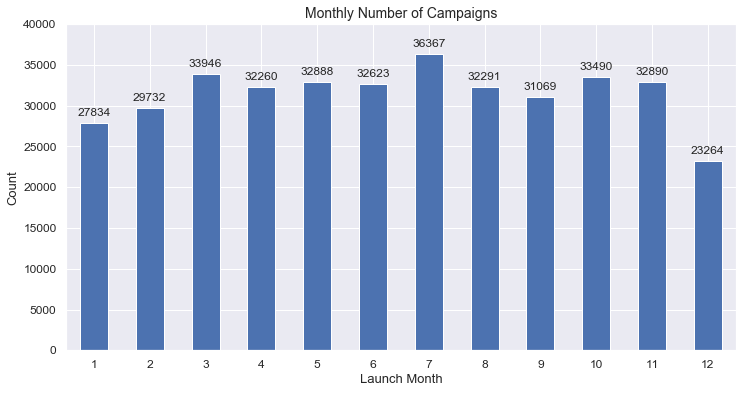

In [13]:
ax=monthlySorted.plot(kind='bar',fontsize=12,figsize=(12,6))
ax.set_title("Monthly Number of Campaigns",fontsize=14)
ax.set_ylabel("Count",fontsize=13)
ax.set_xlabel("Launch Month",fontsize=13)
ax.tick_params(rotation=0)
ax.set_ylim(0,40000)

# Add numbers above bars
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=12)
ax.get_legend().remove()
plt.show()

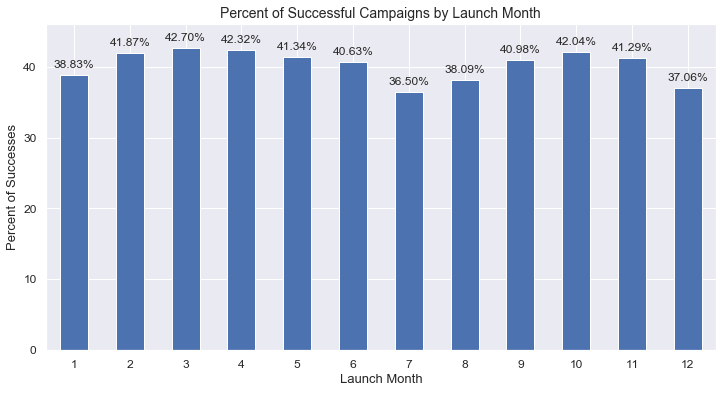

In [15]:
ax=((monthlySuccessSorted)/(monthlySuccessSorted+monthlyFailureSorted)*100).plot(kind='bar',fontsize=12,figsize=(12,6))
ax.set_title("Percent of Successful Campaigns by Launch Month",fontsize=14)
ax.set_ylabel("Percent of Successes",fontsize=13)
ax.set_xlabel("Launch Month",fontsize=13)
ax.tick_params(rotation=0)
ax.set_ylim(0,46)

# Add numbers above bars
for p in ax.patches:
    ax.annotate(str("%.2f"% p.get_height()+"%"),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=12)
ax.get_legend().remove()
plt.show()

### Since the outcome of a kickstarter campaign is categorical, we can one hot encode the outcome column.

In [16]:
one_hot_state=pd.get_dummies(kickstart['state'])
kickstart=kickstart.join(one_hot_state)

### The main_category and currency columns may be used to assist in predictions as well.

In [17]:
one_hot_maincat=pd.get_dummies(kickstart['main_category'])
kickstart=kickstart.join(one_hot_maincat)

In [18]:
one_hot_currency=pd.get_dummies(kickstart['currency'])
kickstart=kickstart.join(one_hot_currency)

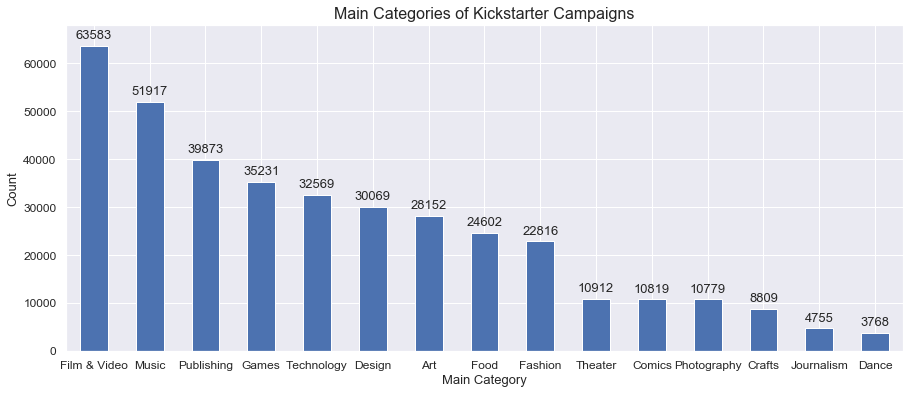

In [19]:
ax=kickstart['main_category'].value_counts().plot(kind='bar',fontsize=12,figsize=(15,6))
ax.set_title("Main Categories of Kickstarter Campaigns",fontsize=16)
ax.set_ylabel("Count",fontsize=13)
ax.set_xlabel("Main Category",fontsize=13)
ax.set_ylim(0,68000)
ax.tick_params(rotation=0)
for p in ax.patches:
    ax.annotate("%.0f" % p.get_height(),
                (p.get_x() + p.get_width() / 2., p.get_height()),
                ha='center', va='center', xytext=(0, 10),
                textcoords='offset points',fontsize=13)
plt.show()

In [20]:
cats=["Film & Video", "Music", "Publishing","Games","Technology","Design","Art","Food","Fashion","Theater","Comics","Photography","Crafts","Journalism","Dance"]
success_rates=[]
filmAndVideo=kickstart[kickstart.main_category=="Film & Video"]
success_rates.append((filmAndVideo.state=="successful").sum()/len(filmAndVideo))

Music=kickstart[kickstart.main_category=="Music"]
success_rates.append((Music.state=="successful").sum()/len(Music))

Publishing=kickstart[kickstart.main_category=="Publishing"]
success_rates.append((Publishing.state=="successful").sum()/len(Publishing))

Games=kickstart[kickstart.main_category=="Games"]
success_rates.append((Games.state=="successful").sum()/len(Games))


Tech=kickstart[kickstart.main_category=="Technology"]
success_rates.append((Tech.state=="successful").sum()/len(Tech))


Design=kickstart[kickstart.main_category=="Design"]
success_rates.append((Design.state=="successful").sum()/len(Design))


Art=kickstart[kickstart.main_category=="Art"]
success_rates.append((Art.state=="successful").sum()/len(Art))

Food=kickstart[kickstart.main_category=="Food"]
success_rates.append((Art.state=="successful").sum()/len(Food))

Fashion=kickstart[kickstart.main_category=="Fashion"]
success_rates.append((Fashion.state=="successful").sum()/len(Fashion))

Theater=kickstart[kickstart.main_category=="Theater"]
success_rates.append((Theater.state=="successful").sum()/len(Theater))

Comics=kickstart[kickstart.main_category=="Comics"]
success_rates.append((Comics.state=="successful").sum()/len(Comics))

Photography=kickstart[kickstart.main_category=="Photography"]
success_rates.append((Photography.state=="successful").sum()/len(Photography))

Crafts=kickstart[kickstart.main_category=="Crafts"]
success_rates.append((Crafts.state=="successful").sum()/len(Crafts))

Journalism=kickstart[kickstart.main_category=="Journalism"]
success_rates.append((Journalism.state=="successful").sum()/len(Journalism))

Dance=kickstart[kickstart.main_category=="Dance"]
success_rates.append((Dance.state=="successful").sum()/len(Dance))
success_rates.sort()

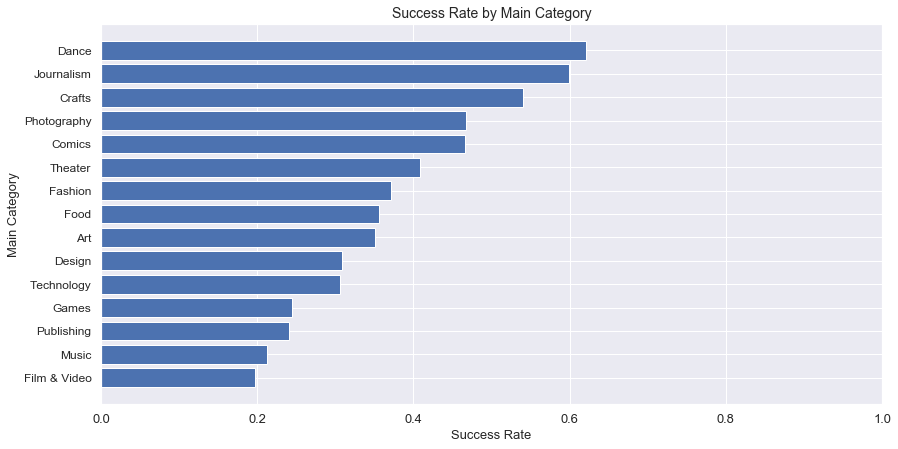

In [21]:
plt.figure(figsize=(14,7))
plt.barh(cats,success_rates)
plt.xlim(0,1)
plt.title("Success Rate by Main Category",fontsize=14)
plt.xlabel("Success Rate",fontsize=13)
plt.ylabel("Main Category",fontsize=13)
plt.xticks(fontsize=13)
plt.yticks(fontsize=12)
plt.show()

# Random Forest Classification - Predicting Success
### Figuring out the most important features

In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

X_cols=['usd_goal_real', 'days', 'launch_month', 'Art', 'Comics',
       'Crafts', 'Dance', 'Design', 'Fashion', 'Film & Video', 'Food', 'Games',
       'Journalism', 'Music', 'Photography', 'Publishing', 'Technology',
       'Theater', 'AUD', 'CAD', 'CHF', 'DKK', 'EUR', 'GBP',
       'HKD', 'JPY', 'MXN', 'NOK', 'NZD', 'SEK', 'SGD', 'USD']
X = kickstart[X_cols]
y = kickstart['successful']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

forest = RandomForestClassifier(n_estimators=200,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.511903 	usd_goal_real
2. feature 1 	0.238724 	days
3. feature 2 	0.152639 	launch_month
4. feature 13 	0.010008 	Art
5. feature 17 	0.009749 	Comics
6. feature 16 	0.008708 	Crafts
7. feature 4 	0.006158 	Dance
8. feature 8 	0.005680 	Design
9. feature 31 	0.005640 	Fashion
10. feature 6 	0.004245 	Film & Video
11. feature 15 	0.003796 	Food
12. feature 10 	0.003777 	Games
13. feature 9 	0.003718 	Journalism
14. feature 22 	0.003385 	Music
15. feature 11 	0.003338 	Photography
16. feature 5 	0.003302 	Publishing
17. feature 23 	0.003272 	Technology
18. feature 7 	0.003054 	Theater
19. feature 3 	0.002750 	AUD
20. feature 19 	0.002491 	CAD
21. feature 14 	0.002339 	CHF
22. feature 12 	0.002285 	DKK
23. feature 18 	0.002011 	EUR
24. feature 29 	0.001244 	GBP
25. feature 26 	0.001089 	HKD
26. feature 28 	0.001017 	JPY
27. feature 21 	0.000901 	MXN
28. feature 24 	0.000692 	NOK
29. feature 20 	0.000685 	NZD
30. feature 27 	0.000684 	SEK
31. feature 30 	0.00

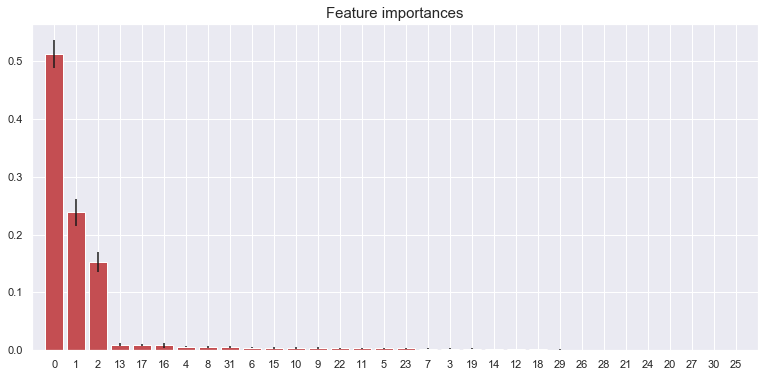

In [24]:
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1, indices[f], importances[indices[f]],X_cols[f]))

# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [25]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

              precision    recall  f1-score   support

           0       0.79      0.70      0.74     55159
           1       0.38      0.50      0.43     20572

    accuracy                           0.64     75731
   macro avg       0.59      0.60      0.59     75731
weighted avg       0.68      0.64      0.66     75731



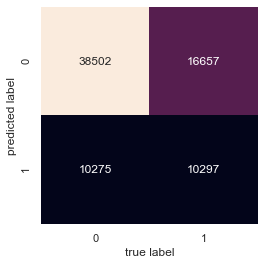

In [26]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### This model seems to do an okay job at classifying unsuccessful campaigns as such, but performs quite poorly when it comes to accurately classifying successful campaigns.

## Predictors - goal, days, launch month

In [27]:
X_cols=['usd_goal_real', 'days', 'launch_month']
X = kickstart[X_cols]
y = kickstart['successful']

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

forest = RandomForestClassifier(n_estimators=100,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.754968 	usd_goal_real
2. feature 1 	0.201385 	days
3. feature 2 	0.043647 	launch_month


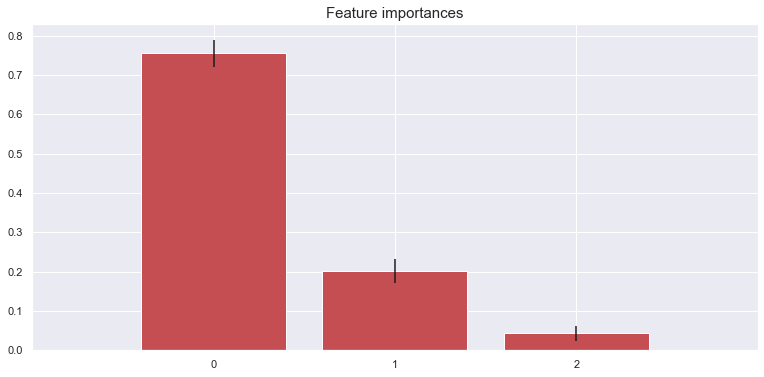

In [28]:
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1, indices[f], importances[indices[f]],X_cols[f]))

# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [29]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74     58081
           1       0.31      0.48      0.38     17650

    accuracy                           0.63     75731
   macro avg       0.56      0.58      0.56     75731
weighted avg       0.69      0.63      0.66     75731



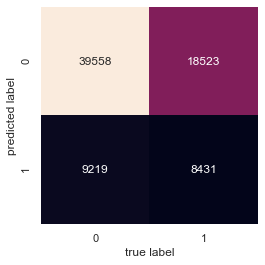

In [30]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [31]:
forest_score = cross_val_score(forest, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % forest_score.mean())

mean accuracy of 10-fold cv: 0.603910


# Random Forest Regressors
### Predicting number of backers using goal, days, launch month

In [32]:
from sklearn.ensemble import RandomForestRegressor
X_cols=['usd_goal_real', 'days', 'launch_month']
X = kickstart[X_cols]
y = kickstart['backers']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)
forest = RandomForestRegressor(n_estimators=200,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.442893 	usd_goal_real
2. feature 2 	0.340464 	days
3. feature 1 	0.216644 	launch_month


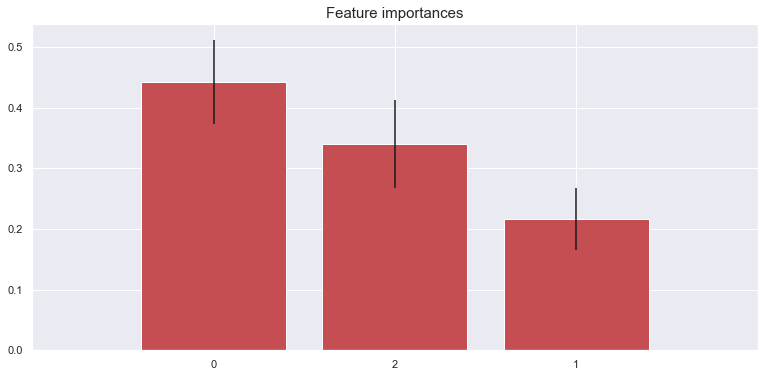

In [33]:
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1, indices[f], importances[indices[f]],X_cols[f]))
    
# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [34]:
forest.score(Xtrain,ytrain)

0.4500221076361868

In [35]:
X_cols=['usd_goal_real', 'days', 'launch_month']
X = kickstart[X_cols]
y = kickstart['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

forest = RandomForestClassifier(n_estimators=200,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.760467 	usd_goal_real
2. feature 1 	0.195137 	days
3. feature 2 	0.044396 	launch_month


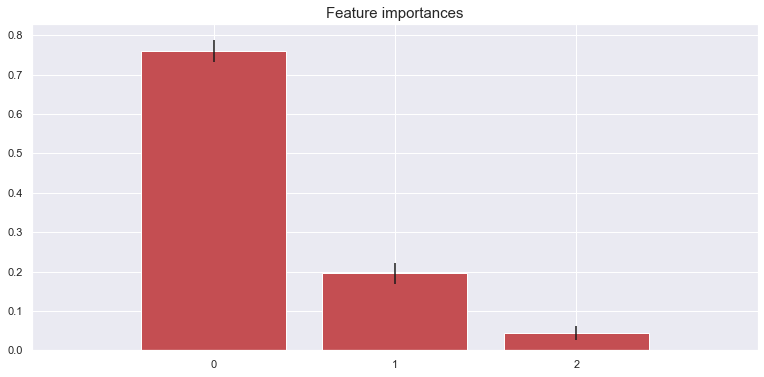

In [36]:
importances = forest.feature_importances_

std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1, indices[f], importances[indices[f]],X_cols[f]))
    
# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [37]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

              precision    recall  f1-score   support

           0       0.81      0.68      0.74     58223
           1       0.31      0.48      0.38     17508

    accuracy                           0.63     75731
   macro avg       0.56      0.58      0.56     75731
weighted avg       0.70      0.63      0.66     75731



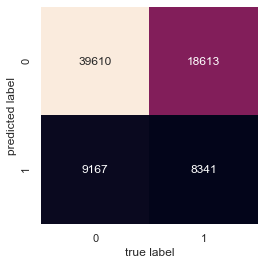

In [38]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [39]:
forest_score = cross_val_score(forest, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % forest_score.mean())

mean accuracy of 10-fold cv: 0.603464


In [40]:
y_prob = forest.predict_proba(Xtrain)

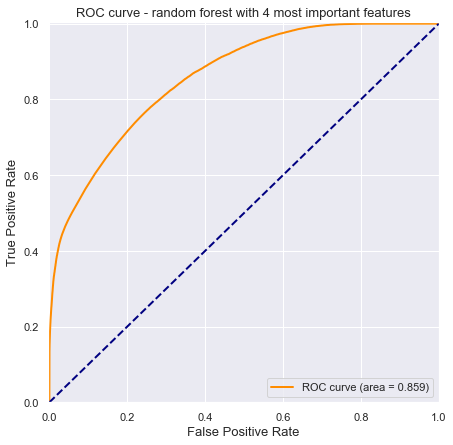

In [41]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.003, 1])
plt.ylim([0, 1.005])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - random forest with 4 most important features',fontsize=13)
plt.legend(loc="lower right")
plt.show()

## Since we did not use the launch year as a predictor, as that cannot be controlled, we create a model for a few individual years to assess the predictive power these models may have.

In [53]:
kickstart_2015=kickstart[kickstart.launched.dt.year==2015]

In [64]:
kickstart_2015.shape

(77300, 56)

In [65]:
X_cols=['usd_goal_real','days', 'launch_month']
X=kickstart_2015[X_cols]
y=kickstart_2015['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=y)

forest=RandomForestClassifier(n_estimators=100)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	0.718266 	usd_goal_real
2. feature 1 	0.223635 	days
3. feature 2 	0.058098 	launch_month


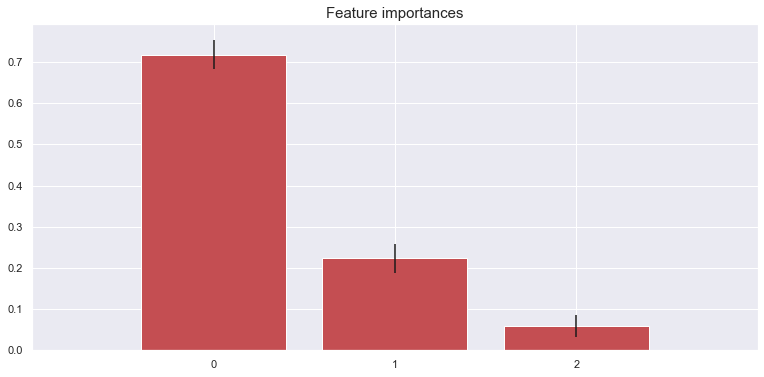

In [66]:
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1,
                                        indices[f],
                                        importances[indices[f]],
                                        X_cols[f]))

# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [67]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

              precision    recall  f1-score   support

           0       0.85      0.75      0.80     12821
           1       0.24      0.38      0.29      2639

    accuracy                           0.69     15460
   macro avg       0.55      0.56      0.55     15460
weighted avg       0.75      0.69      0.71     15460



In [68]:
forest_score = cross_val_score(forest, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % forest_score.mean())

mean accuracy of 10-fold cv: 0.589017


In [69]:
y_prob = forest.predict_proba(Xtrain)

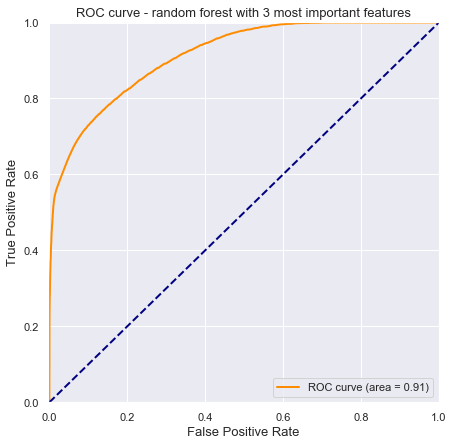

In [71]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.002])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - random forest with 3 most important features',fontsize=13)
plt.legend(loc="lower right")
plt.show()

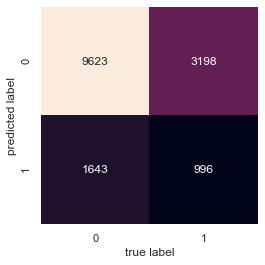

In [72]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [73]:
X_cols=['usd_goal_real']
X=kickstart_2015[X_cols]
y=kickstart_2015['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0,
                                                stratify=y)

forest=RandomForestClassifier(n_estimators=100,n_jobs=-1)
forest.fit(Xtrain,ytrain);

Feature ranking:
1. feature 0 	1.000000 	usd_goal_real


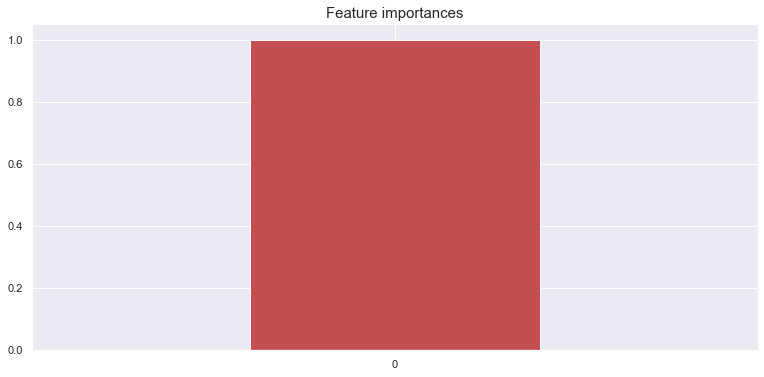

In [74]:
importances = forest.feature_importances_
std = np.std([forest.feature_importances_ for forest in forest.estimators_],
             axis=0)

# sort the features by importance
indices = np.argsort(importances)[::-1]
# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d \t%f \t%s" % (f + 1,
                                        indices[f],
                                        importances[indices[f]],
                                        X_cols[f]))

# Plot the feature importances of the forest
plt.figure(figsize=(13,6))
plt.title("Feature importances",fontsize=15)
plt.bar(range(Xtrain.shape[1]), importances[indices],
        color="r",
        yerr=std[indices],
        align="center")
plt.xticks(range(Xtrain.shape[1]), indices)
plt.xlim([-1, Xtrain.shape[1]])
plt.show()

In [75]:
y_pred = forest.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

              precision    recall  f1-score   support

           0       0.93      0.74      0.82     14203
           1       0.11      0.37      0.17      1257

    accuracy                           0.71     15460
   macro avg       0.52      0.55      0.50     15460
weighted avg       0.86      0.71      0.77     15460



In [76]:
forest_score = cross_val_score(forest, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % forest_score.mean())

mean accuracy of 10-fold cv: 0.699728


In [77]:
y_prob = forest.predict_proba(Xtrain)

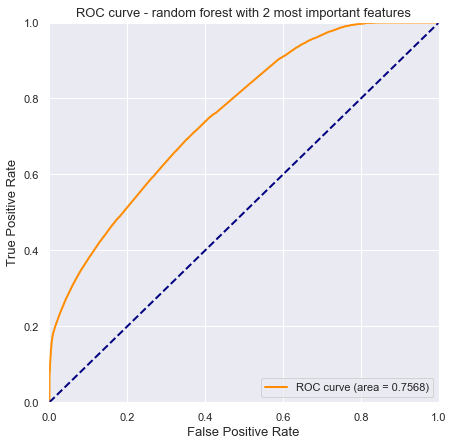

In [78]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.003, 1.0])
plt.ylim([0.0, 1.002])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - random forest with 2 most important features',fontsize=13)
plt.legend(loc="lower right")
plt.show()

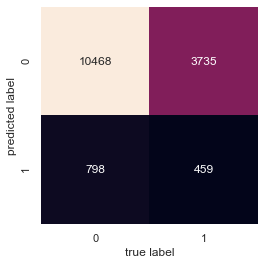

In [79]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Unsurprisingly, these models perform very well, as they essentially use an output variable that is closely related to the success as an input in order to predict the success.

### Since we are predicting a binary outcome, we will now see if a simpler, single variable input (one of the several most important features from the random forest) with logistic regression can be used to predict the success of a campaign.

### Our first model will use the usd_goal_real column as the predictor.

In [108]:
from sklearn.linear_model import LogisticRegression

X=kickstart.usd_goal_real.values.reshape(-1,1)
y=kickstart.successful.values

Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)
logit = LogisticRegression()
logit.fit(X,y)

print('The accuracy of the model is: %f' % logit.score(X,y))
print('Accuracy of model which guesses failure everytime %f' % (len(kickstart[kickstart.successful == 0])/len(kickstart[(kickstart.successful == 1) | (kickstart.successful == 0)])))

The accuracy of the model is: 0.646231
Accuracy of model which guesses failure everytime 0.646231


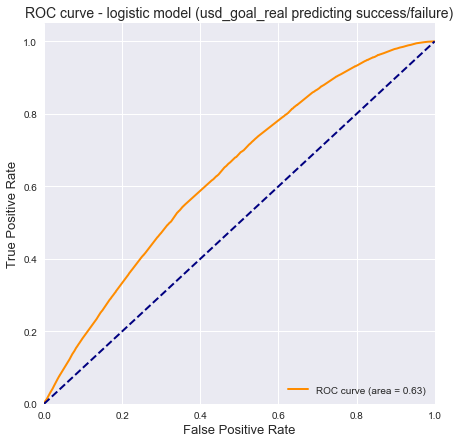

In [109]:
y_prob = logit.predict_proba(Xtrain)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - logistic model (usd_goal_real predicting success/failure)',fontsize=14)
plt.legend(loc="lower right")
plt.show()

             precision    recall  f1-score   support

          0       1.00      0.64      0.78     75731
          1       0.00      0.00      0.00         0

avg / total       1.00      0.64      0.78     75731



/Users/chrisrutherford/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1137: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


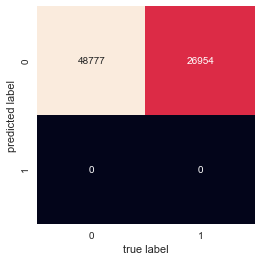

In [110]:
y_pred = logit.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### Evidently, this model won't be of much use at all, since it predicts failure every time. Hopefully a different predictor will be more accurate.

## Logistic Model - Predictor: Length of Campaign in Days

In [111]:
X = kickstart.days.values.reshape(-1,1)
y = kickstart['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

logit.fit(Xtrain,ytrain)

print('The accuracy of the model is: %f' % logit.score(X,y))
print('Accuracy of model which guesses failure everytime: %f' % (len(kickstart[kickstart.successful == 0])/len(kickstart[(kickstart.successful == 1) | (kickstart.successful == 0)])))

The accuracy of the model is: 0.645684
Accuracy of model which guesses failure everytime: 0.646231


             precision    recall  f1-score   support

          0       1.00      0.64      0.78     75591
          1       0.00      0.41      0.00       140

avg / total       1.00      0.64      0.78     75731



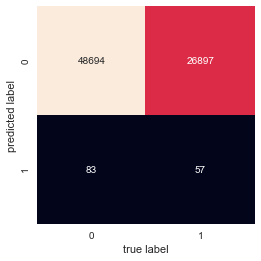

In [112]:
y_pred = logit.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

### This model is not very useful either, likely due to complex relationship between the length of the campaign and the outcome, as seen in the graph of days vs. ratio.

In [113]:
X = kickstart.backers.values.reshape(-1,1)
y = kickstart['successful']
Xtrain, Xtest, ytrain, ytest = train_test_split(X,y,
                                                test_size=0.2,
                                                random_state=0)

logit.fit(Xtrain,ytrain)
print('The accuracy of the model is: %f' % logit.score(X,y))
print('Accuracy of model which guesses failure everytime: %f' % (len(kickstart[kickstart.successful == 0])/len(kickstart[(kickstart.successful == 1) | (kickstart.successful == 0)])))

The accuracy of the model is: 0.783219
Accuracy of model which guesses failure everytime: 0.646231


In [114]:
y_pred = logit.predict(Xtest)
print(metrics.classification_report(y_pred, ytest))

             precision    recall  f1-score   support

          0       0.95      0.77      0.85     60709
          1       0.47      0.85      0.60     15022

avg / total       0.86      0.78      0.80     75731



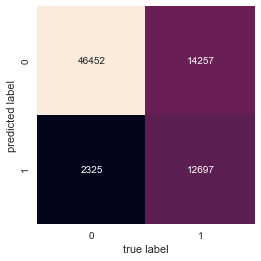

In [115]:
mat = metrics.confusion_matrix(ytest, y_pred)
plt.figure(figsize=(4, 4))
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False)
plt.xlabel('true label')
plt.ylabel('predicted label');

In [116]:
y_prob = logit.predict_proba(Xtrain)

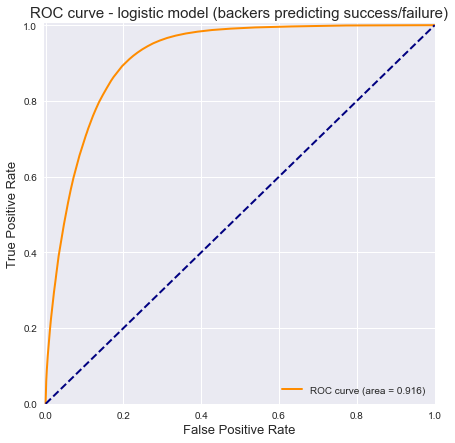

In [117]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(2):
    fpr[i], tpr[i], _ = roc_curve(ytrain[:], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
plt.figure(figsize=(7,7))
lw = 2
plt.plot(fpr[1], tpr[1], color='darkorange',
         lw=lw, label='ROC curve (area = %0.3f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([-0.004, 1.0])
plt.ylim([0.0, 1.005])
plt.xlabel('False Positive Rate',fontsize=13)
plt.ylabel('True Positive Rate',fontsize=13)
plt.title('ROC curve - logistic model (backers predicting success/failure)',fontsize=15)
plt.legend(loc="lower right")
plt.show()

In [118]:
logit_score = cross_val_score(logit, X, y, cv=10, scoring='accuracy', 
                                       n_jobs=-1, verbose=0)
print('mean accuracy of 10-fold cv: %f' % logit_score.mean())

mean accuracy of 10-fold cv: 0.782593


## The complex relationships between the variables indicate that more complex models, like  random forests, are beneficial in making more accurate predictions.

### Main long-term goals: fine tuning parameters of random forests (classifiers and regressors), testing and fitting more models (especially making use of features that were generated but not used)
## -------------------------------------------------------------------
# Ideally, a separate model would be created for each year. The current model includes every year, which is not helpful in making a campaign successful - a campaign created in 2020 cannot be published in 2016.
## Future plans/analyses will amend this issue to address feature importance more accurately.